## Vector Search on Azure Cache for Redis

#### Set environment variables

In [1]:
from dotenv import load_dotenv
import os
import openai
import warnings

warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

load_dotenv()

redis_host  = os.getenv("REDIS_HOST")
if redis_host is None or redis_host == "":
    print("REDIS_HOST environment variable not set.")
    exit()

redis_port  = os.getenv("REDIS_PORT")
if redis_port is None or redis_port == "":
    print("REDIS_PORT environment variable not set.")
    exit()

redis_password  = os.getenv("REDIS_PASSWORD")
if redis_password is None or redis_password == "":
    print("REDIS_PASSWORD environment variable not set.")
    exit()

aoai_key  = os.getenv("AZURE_OPENAI_KEY")
if aoai_key is None or aoai_key == "":
    print("AZURE_OPENAI_KEY environment variable not set.")
    exit()

com_vision_key  = os.getenv("COMPUTER_VISION_KEY")
if com_vision_key is None or com_vision_key == "":
    print("COMPUTER_VISION_KEY environment variable not set.")
    exit()

aoai_api_version = '2023-08-01-preview'

# replace it with the deployment name of your AOAI model
aoai_embedding_deployed_model = 'ada-deployment'

com_vision_endpoint = os.environ.get("COMPUTER_VISION_ENDPOINT")

openai.api_type = "azure"
openai.api_key = os.environ.get("AZURE_OPENAI_KEY")
openai.api_base = os.environ.get("AZURE_OPENAI_URL")
openai.api_version = os.environ.get("AOAI_EMBEDDING_DEPLOYMENT")

text_table_name = 'text_sample'
doc_table_name = 'doc_sample'
image_table_name = 'image_sample'

#### Setup Redis connection

In [16]:
import redis
from redis.commands.search.query import Query
import os

# Connect to Redis
redis_client = redis.Redis(
    host=redis_host,
    port=redis_port,
    ssl=True,
    password=redis_password
)

# should return True
redis_client.ping()

True

#### Redis Vector Search

In [17]:
from typing import List
import numpy as np
from openai.embeddings_utils import get_embedding

def search_redis(
    redis_client: redis.Redis,
    user_query: str,
    index_name: str,
    vector_field: str, 
    return_fields: list = ["title", "category", "content", "vector_score"],
    hybrid_fields = "*",
    k: int = 20,
) -> List[dict]:
    try:
        query_vector = get_embedding(user_query, engine = aoai_embedding_deployed_model)
    except Exception as e:
        print(e)
        return []

    # Prepare the Query
    base_query = f'{hybrid_fields}=>[KNN {k} @{vector_field} $vector AS vector_score]'
    
    query = (
        Query(base_query)
         .return_fields(*return_fields)
         .sort_by("vector_score")
         .paging(0, k)
         .dialect(2)
    )
    params_dict = {"vector": np.array(query_vector).astype(dtype=np.float32).tobytes()}

    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    return results

#### Simple vector search

In [50]:
text_search_field = "title_vector"
text_return_fields = ["title", "category", "content", "vector_score"]
results = search_redis(redis_client, 'products to store unstructured documents', text_table_name, text_search_field, text_return_fields, k=10)
for i, article in enumerate(results.docs):
        score = 1 - float(article.vector_score)
        print(f"{i}. {article.title} (Score: {round(score ,3) })")

0. Azure Queue Storage (Score: 0.766)
1. Azure Blob Storage (Score: 0.765)
2. Azure Table Storage (Score: 0.762)
3. Azure Storage (Score: 0.76)
4. Azure Cognitive Search (Score: 0.751)
5. Azure File Storage (Score: 0.749)
6. Azure Data Lake Storage (Score: 0.745)
7. Azure Cognitive Services (Score: 0.742)
8. Azure Cognitive Services (Score: 0.742)
9. Azure Data Box (Score: 0.741)


#### Document search example

In [51]:
# employee search
doc_search_field = "chunk_content_vector"
doc_search_return_fields = ["chunk_content"]
results = search_redis(redis_client, 'what are the company values', doc_table_name, doc_search_field, doc_search_return_fields, k=1)
for i, article in enumerate(results.docs):
        print(f"{i}. {article.chunk_content}")

0. customers.  
 
Company Values:  
1. Quality: We strive to provide the highest quality products and services to our customers.  
2. Integrity: We value honesty, respect, and t rustworthiness in all our interactions.  
3. Innovation: We encourage creativity and support new ideas and approaches to our 
business.  
4. Teamwork: We believe that by working together, we can achieve greater success.  
5. Respect: We treat all our employees, c ustomers, and partners with respect and dignity.  
6. Excellence: We strive to exceed expectations and provide excellent service.   7. Accountability: We take responsibility for our actions and hold ourselves and others 
accountable for their performance.  
8. Co mmunity: We are committed to making a positive impact in the communities in which 
we work and live.  
Performance Reviews  
 
Performance Reviews at Contoso Electronics  
 
At Contoso Electronics, we strive to ensure our employees are getting the feedback they


In [14]:
import requests
import matplotlib.pyplot as plt
from PIL import Image

def vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query):
    vectorize_text_url = f"{com_vision_endpoint}/computervision/retrieval:vectorizeText"  
    params = {  
        "api-version": "2023-02-01-preview"  
    } 
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": com_vision_key  
    }  
    data = {
        'text':query
    }

    response = requests.post(vectorize_text_url, params=params, headers=headers, json=data)
    query_vector = response.json()["vector"]

    return query_vector

def show_image(image_folder, image):
    image_path = os.path.join(image_folder, image)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()

#### Image search
Using the Azure Cognitive Services Vision API, we convert the user query (string) to an embedded vector. We then use the vector search to find the most similar images in the database.

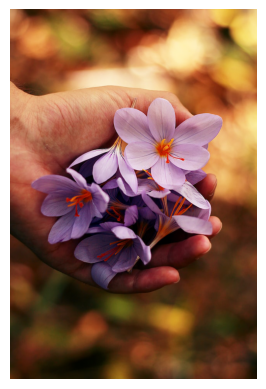

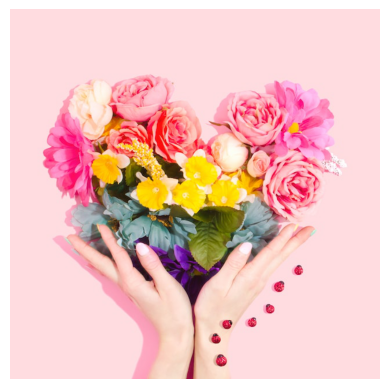

In [24]:
query = 'flowers in a hand'
query_vector = vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query)
image_folder = "../data/images"
num_of_images = 2

base_query = f'*=>[KNN {num_of_images} @image_vector $vector AS vector_score]'
    
query = (
    Query(base_query)
        .return_fields(*["image", "vector_score"])
        .sort_by("vector_score")
        .dialect(2)
)
params_dict = {"vector": np.array(query_vector).astype(dtype=np.float32).tobytes()}

# perform vector search
results = redis_client.ft(image_table_name).search(query, params_dict)

for i, image in enumerate(results.docs):
    show_image(image_folder, image.image)
    print("\n")

#### Hybrid search
Hybrid search in Redis is done by applying a pre-filtering query to the index, and then applying a vector search to the results of the pre-filtering query.

In [52]:
text_search_field = "title_vector"
text_return_fields = ["title", "category", "content", "vector_score"]
hybrid_query = "(@category:Databases)"

results = search_redis(redis_client, 'products to store unstructured documents', text_table_name, text_search_field, text_return_fields,hybrid_query, k=10)
for i, article in enumerate(results.docs):
        score = 1 - float(article.vector_score)
        print(f"{i}. {article.title} (Score: {round(score ,3) })")

0. Azure SQL Data Warehouse (Score: 0.739)
1. Azure Cosmos DB (Score: 0.738)
2. Azure Cosmos DB (Score: 0.738)
3. Azure Database Migration Service (Score: 0.725)
4. Azure Database for PostgreSQL (Score: 0.723)
5. Azure Database for MySQL (Score: 0.721)
6. Azure SQL Database (Score: 0.72)
7. Azure Cache for Redis (Score: 0.717)
8. Azure SQL Managed Instance (Score: 0.712)
9. Azure Database for MariaDB (Score: 0.71)


#### Range Query on Azure Cache for Redis

It is possible to define a range query on a vector index. The range query is defined by a center vector and a radius. Given the search query (center vector), the result will be all vectors that are within the radius from the center vector.

In [54]:
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity

text_search_field = "title_vector"
text_return_fields = ["title", "category", "content", "vector_score"]
range_radius = 0.2
search_query = 'store a blob'

base_vector_query = f'@{text_search_field}:[VECTOR_RANGE {range_radius} $vector]=>{{$yield_distance_as: vector_score}}'

try:
    query_vector = get_embedding(search_query, engine = aoai_embedding_deployed_model)
except Exception as e:
    print(e)
    
query = (
        Query(base_vector_query)
         .return_fields(*text_return_fields)
         .sort_by("vector_score")
         .dialect(2)
    )
params_dict = {"vector": np.array(query_vector).astype(dtype=np.float32).tobytes()}

# perform vector range query search
results = redis_client.ft(text_table_name).search(query, params_dict)
    
for i, article in enumerate(results.docs):
        print(f"{i}. {article.title} (Close by: {article.vector_score})")     


0. Azure Blob Storage (Close by: 0.13201379776)
1. Azure Table Storage (Close by: 0.190510332584)
2. Azure Storage (Close by: 0.192014217377)
3. Azure File Storage (Close by: 0.197330653667)
